<a href="https://colab.research.google.com/github/iswahyudi030303/Deteksi-Paru-MobileNetV2/blob/main/Deteksi_Paru_Kelompok_1B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
np.random.seed(0)
seed = 0
import warnings
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import matplotlib.patches as mpatches
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
IMG_SIZE = 255
x_train = []
y_label = []

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Dataset Stechoq/Deteksi Paru2'):
    print(dirname)
    for filename in filenames:
        im = cv2.imread(dirname+"/"+filename)
        img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        new_array = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        if 'Normal' in dirname:
            y_label.append(0)
            x_train.append(new_array)
        elif 'Pneumonia' in dirname:
            y_label.append(1)
            x_train.append(new_array)
        elif 'Pneumothorax' in dirname:
            y_label.append(2)
            x_train.append(new_array)


/content/drive/MyDrive/Dataset Stechoq/Deteksi Paru2
/content/drive/MyDrive/Dataset Stechoq/Deteksi Paru2/Pneumothorax
/content/drive/MyDrive/Dataset Stechoq/Deteksi Paru2/Normal
/content/drive/MyDrive/Dataset Stechoq/Deteksi Paru2/Pneumonia


In [ ]:
x_train = np.array(x_train)
x_train.shape

(4377, 255, 255, 3)

In [ ]:
y_label = np.array(y_label)
y_label = pd.get_dummies(y_label)
y_label.shape

(4377, 3)

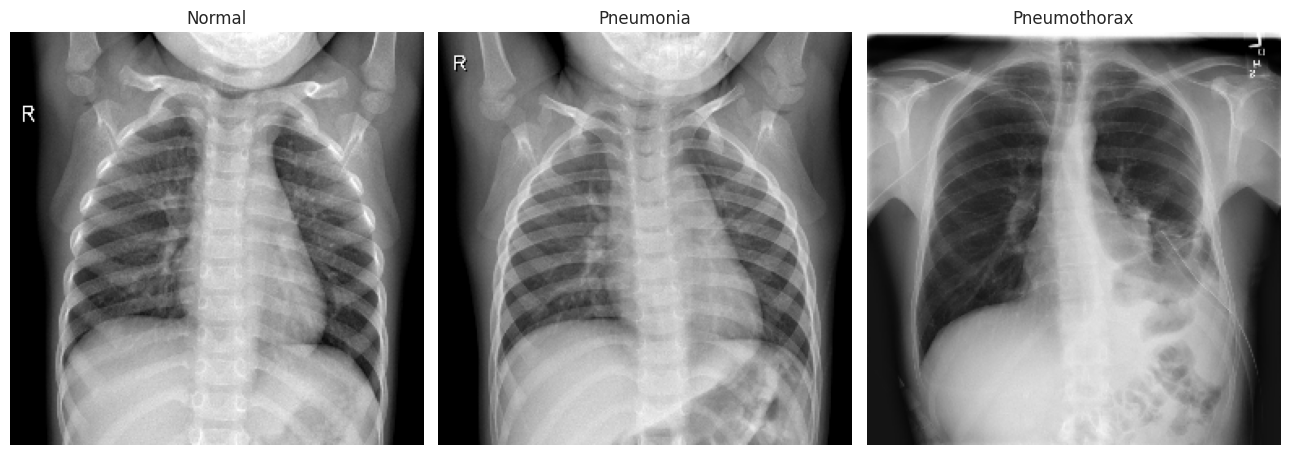

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(13,6))
title = ["Normal",
         "Pneumonia",
         "Pneumothorax"]
for i in range(3):
    rand_ind = np.random.randint(0, y_label[y_label==i].shape[0])
    axes[i].imshow(x_train[rand_ind])
    axes[i].set_title(title[i])
    axes[i].axis('off')
plt.tight_layout()
plt.show()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    x_train, y_label, test_size=0.3, random_state=seed
)

In [ ]:
X_train.shape

(3063, 255, 255, 3)

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=30,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest'
                                  )

for i in range(0,2284):
    img_tensor = np.expand_dims(X_train[i], axis=0)
    pic = train_datagen.flow(img_tensor,batch_size =1, seed=0)
    batch = pic.next()
    image_ = batch[0].astype('uint8')
    X_train = np.append(X_train, [image_], axis=0)
print(image_.shape)

(255, 255, 3)


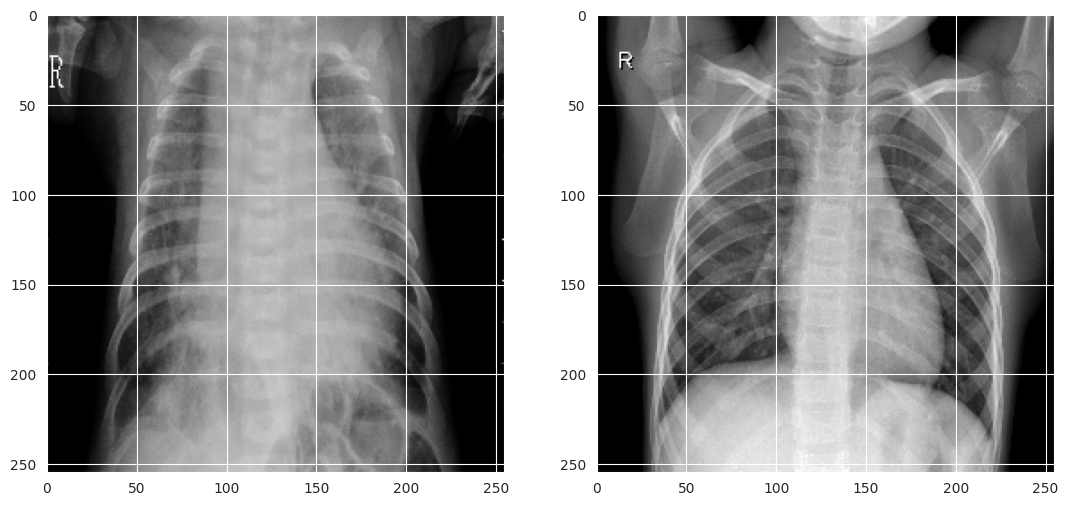

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(13,6))
axes[0].imshow(X_train[0])
axes[1].imshow(X_train[0+2284])

In [ ]:
y_train = pd.concat([y_train,y_train])
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
y_train

array([[False,  True, False],
       [False, False,  True],
       [False,  True, False],
       ...,
       [False, False,  True],
       [ True, False, False],
       [ True, False, False]])

In [ ]:
IMG_SIZE = 255
import tensorflow.keras as keras
model_mobilenet = keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
model_mobilenet.trainable = False
final_output = model_mobilenet.output
trainable_parameters = sum([w.shape.num_elements() for w in model_mobilenet.trainable_weights])

In [ ]:
n_layer = layers.Flatten()(final_output)
nplus_layer = layers.Dense(1024, activation="relu")(n_layer)
nplus_layer = layers.Dropout(0.5)(nplus_layer)

# Ubah jumlah node output sesuai dengan jumlah kelas (3)
final_layer = layers.Dense(3, activation="softmax")(nplus_layer)

optimizer = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999)

model_transfer_learning = keras.Model(inputs=model_mobilenet.input, outputs=final_layer)
model_transfer_learning.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
epochs = 20
batch_size = 40
len(model_transfer_learning.layers)


158

In [ ]:
fine_tune_layer = 100
model_transfer_learning.trainable = True
for layer in model_transfer_learning.layers[:fine_tune_layer]:
    layer.trainable = False
len(model_transfer_learning.trainable_variables)

58

In [ ]:
model_transfer_learning.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 255, 255, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 128, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 128, 128, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 128, 128, 32)         0         ['bn_Conv1[0][0]']        

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
new_model_result = model_transfer_learning.fit(X_train, y_train,
                         batch_size=batch_size,
                         epochs=epochs,
                         validation_split=0.2,
                         callbacks=[reduce_lr])

Epoch 1/20
107/107 [==============================] - 464s 4s/step - loss: 0.3204 - accuracy: 0.8913 - val_loss: 0.1182 - val_accuracy: 0.9523 - lr: 1.0000e-05
Epoch 2/20
107/107 [==============================] - 468s 4s/step - loss: 0.1240 - accuracy: 0.9523 - val_loss: 0.1023 - val_accuracy: 0.9589 - lr: 1.0000e-05
Epoch 3/20
107/107 [==============================] - 481s 5s/step - loss: 0.0763 - accuracy: 0.9724 - val_loss: 0.1120 - val_accuracy: 0.9561 - lr: 1.0000e-05
Epoch 4/20
107/107 [==============================] - 462s 4s/step - loss: 0.0653 - accuracy: 0.9750 - val_loss: 0.0819 - val_accuracy: 0.9654 - lr: 1.0000e-05
Epoch 5/20
107/107 [==============================] - 438s 4s/step - loss: 0.0455 - accuracy: 0.9843 - val_loss: 0.0787 - val_accuracy: 0.9645 - lr: 1.0000e-05
Epoch 6/20
107/107 [==============================] - 462s 4s/step - loss: 0.0303 - accuracy: 0.9902 - val_loss: 0.1390 - val_accuracy: 0.9523 - lr: 1.0000e-05
Epoch 7/20
107/107 [====================